In [36]:
import importlib

import dataset, metrics, plotting, config
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

<module 'models.reg_cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/reg_cgan_model.py'>

In [37]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "magical_sinus"
       or dataset_config.scenario == "hdpeuce"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [38]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.001, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=200),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=True)
)

In [39]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [40]:
X_train, y_train, _, _ = dataset.get_dataset(exp_config.dataset.n_instance, exp_config.dataset.scenario)

## Gaussian Process 

In [41]:
import GPy

noise = 4.3
length = 16

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True)

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


## Construct CGAN model

In [42]:
regcgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = regcgan.train(X_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 2)            0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 20)           60          Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 20)           120         Generator_input_z[0][0]          
__________________________________________________________________________________________________
concatenat

 /Users/zhongsheng/anaconda2/envs/Reg-CGAN/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


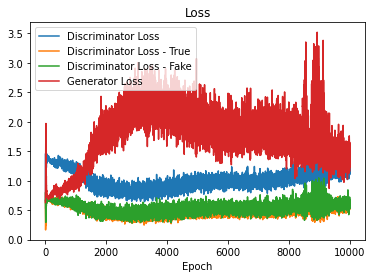

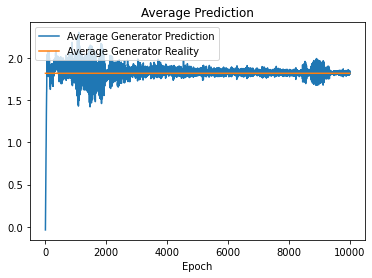

In [43]:
plotting.plot_training_curve(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## Generate pairs of virtual samples

In [44]:
from os.path import basename
X_CVT = np.load(f"{fig_dir}/{basename(fig_dir)}_cvt_samples.npy")

In [45]:
from dataset import _magical_sinus
y = _magical_sinus(X_CVT[:,0], X_CVT[:,1]).reshape(-1, 1)

In [46]:
ypred_regcgan_cvt = regcgan.predict(X_CVT)
ypred_gp_cvt, cov_cvt = gpr.predict(X_CVT)


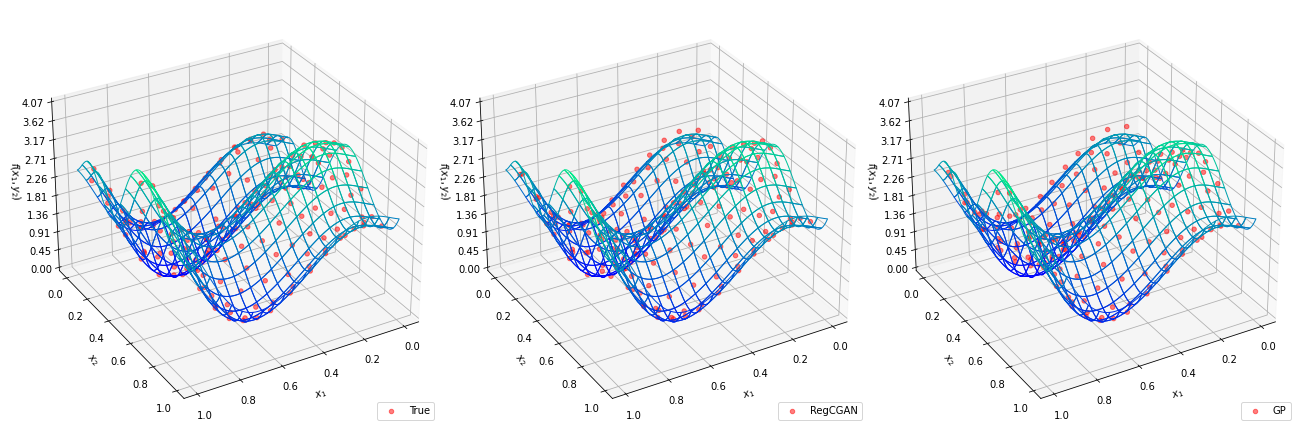

In [47]:
plotting.plot_ypred_with_locations(X_CVT, y, ypred_regcgan_cvt, ypred_gp_cvt,
                          fig_dir=fig_dir, prefix="regcgan_gp", save_fig=exp_config.run.save_fig,
                          alpha=0.5, elevation=30, azimuth=60)

## Marginalized density P(y)

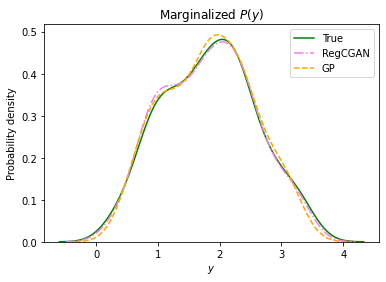

In [48]:
plotting.plot_densities_joint(y, ypred_regcgan_cvt, ypred_gp_cvt,
                              title=r"Marginalized $P(y)$", fig_dir=fig_dir,
                              prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

## Conditional density P(y|x)

In [49]:
ypred_regcgan_sam = regcgan._make_sampling(X_CVT)

ypred_gp, cov = gpr.predict(X_CVT)
ypred_gp_sam = np.random.normal(ypred_gp, np.sqrt(cov))
for i in range(1, exp_config.training.n_sampling):
    ypred_gp_sam = np.hstack([ypred_gp_sam, np.random.normal(ypred_gp, np.sqrt(cov))])

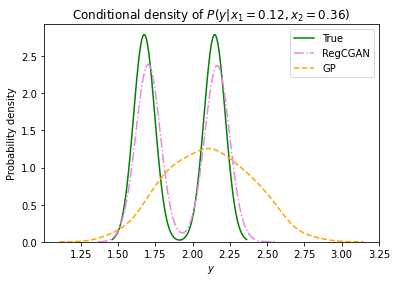

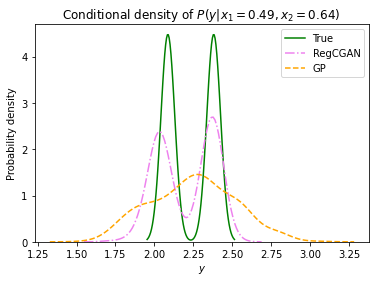

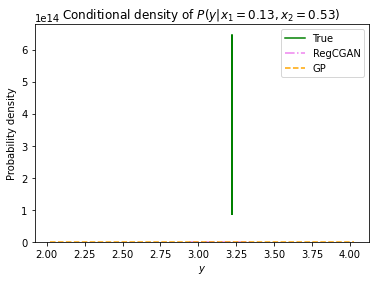

In [50]:
bins =[[0.12, 0.36], [0.49, 0.64], [0.13, 0.53]]
for (x1, x2) in bins:
    y_true_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (exp_config.training.n_sampling, 1)),
                                        y=np.tile(y, (exp_config.training.n_sampling, 1)))

    ypred_regcgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (exp_config.training.n_sampling, 1)),
                                        y=np.ravel(ypred_regcgan_sam.T).reshape(-1, 1))

    ypred_gp_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (exp_config.training.n_sampling, 1)),
                                        y=np.ravel(ypred_gp_sam.T).reshape(-1, 1))

    (y_true_cond, ypred_regcgan_cond, ypred_gp_cond) = (y_true_cond.reshape(-1, 1),
                                                      ypred_regcgan_cond.reshape(-1, 1),
                                                      ypred_gp_cond.reshape(-1, 1))

    plotting.plot_densities_joint(y_true_cond.reshape(-1, 1),
                                          ypred_regcgan_cond.reshape(-1, 1),
                                          ypred_gp_cond.reshape(-1, 1),
                                          title = f"Conditional density of $P(y|x_1={x1},x_2={x2})$ ", fig_dir=fig_dir,
                                          prefix=f"condition_density_P(y|x1={x1},x2={x2})", save_fig=exp_config.run.save_fig)




## Metrics on virtual samples

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

regcgan_mae_list = []
regcgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 10
for i in range(n_eval_runs):

    ypred_regcgan = regcgan.predict(X_CVT)
    regcgan_mae_list.append(mean_absolute_error(y, ypred_regcgan))
    regcgan_mse_list.append(mean_squared_error(y, ypred_regcgan))

    yped_gp = np.random.normal(ypred_gp_cvt, np.sqrt(cov_cvt))
    gp_mae_list.append(mean_absolute_error(y, yped_gp))
    gp_mse_list.append(mean_squared_error(y, yped_gp))


In [52]:
regcgan_mae_mean, regcgan_mae_std = np.mean(np.asarray(regcgan_mae_list)), np.std(np.asarray(regcgan_mae_list))
regcgan_mse_mean, regcgan_mse_std = np.mean(np.asarray(regcgan_mse_list)), np.std(np.asarray(regcgan_mse_list))

print(f"MAE for RegCGAN: {regcgan_mae_mean:.3f} +- {regcgan_mae_std:.5f}")
print(f"MSE for RegCGAN: {regcgan_mse_mean:.3f} +- {regcgan_mse_std:.5f}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"MAE for GP: {gp_mae_mean:.3f} +- {gp_mae_std:.5f}")
print(f"MSE for GP: {gp_mse_mean:.3f} +- {gp_mse_std:.5f}")

MAE for RegCGAN: 0.057 +- 0.00025
MSE for RegCGAN: 0.005 +- 0.00004
MAE for GP: 0.236 +- 0.01014
MSE for GP: 0.087 +- 0.00702


In [53]:
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.gaussian_NLPD(y, np.random.normal(ypred_gp_cvt, np.sqrt(cov_cvt)), cov_cvt))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"NLPD for GP: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

NLPD for GP: 0.182 +- 0.07534


In [ ]:
regcgan_nlpd_train, w, lls = metrics.Parzen(regcgan, X_train, y_train)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(regcgan, X_CVT, y, w, exp_config.training.n_sampling))
regcgan_nlpd_mean = np.mean(nlpd_list)
regcgan_nlpd_std = np.std(nlpd_list)
print(f"NLPD for RegCGAN:  {regcgan_nlpd_mean:.3f} +- {regcgan_nlpd_std:.5f}")

In [57]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_virtual_samples.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"=== MAE ===\n")
    file.write(f"MAE for GP: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"MAE for RegCGAN: {regcgan_mae_mean} +- {regcgan_mae_std}\n")
    file.write(f"=== MSE ===\n")
    file.write(f"MSE for GP : {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"MSE for CGAN: {regcgan_mse_mean} +- {regcgan_mse_std}\n")
    file.write(f"=== NLPD ===\n")
    file.write(f"NLPD for GP: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"NLPD for RegCGAN: {regcgan_nlpd_mean} +- {regcgan_nlpd_std}\n")
    file.close()
